In [1]:
import os
from utils import *
import joblib
os.listdir('../model')

['Critic.pkl', 'PAagent.pkl', 'stream_lasso_weight.pkl']

In [2]:
os.listdir('../data')

['dataset.pkl',
 'PA_201605-2020001更新R10(20200602).csv',
 'tag_cleaned.csv',
 'tag盤點表20200423.xlsx',
 'tag盤點表20200602R1.xlsx',
 'train_cleaned.csv',
 '反應槽(20200201-20200212)開車資料.csv']

In [3]:
tag = pd.read_excel('../data/tag盤點表20200602R1.xlsx')
tag = tag[['TAG','chinese','min','max']]
tag = tag.set_index('TAG')

In [4]:
agent = joblib.load('../model/PAagent.pkl')

In [5]:
set_state = [0.99,30]
set_request = 8000

In [6]:
state = set_state
request = set_request
advice,output,stream,單耗,蒸氣單耗 = agent.get_advice(state,request)
print('state',state)
print('request',request)
print('output',output[0][0])
print('stream',stream[0][0])
print('單耗',單耗)
print('蒸氣單耗',蒸氣單耗)
c1 = tag.loc[advice.index,'min'] - advice['min'] > 0
c2 = tag.loc[advice.index,'max'] - advice['max'] < 0
advice['超出規格'] = c1|c2
advice

state [0.99, 30]
request 8000
output 7864.9673
stream 57145.176
單耗 0.8920972
蒸氣單耗 0.12278053


,chinese,mean,max,min,超出規格
MLPAP_FQ-0619.PV,OX入料量,7016.314941,7016.677734,7015.775391,False
MLPAP_TJC-0627.PV,OX預熱器出口溫度,150.557678,150.559982,150.555984,False
MLPAP_TRC-0610.PV,空氣預熱器出口溫度,180.366760,180.371277,180.358810,False
MLPAP_FR-0632.PV,汽機風量,74.791733,74.794136,74.787735,False
MLPAP_TJC-0757A.PV,反應槽鹽浴溫度,356.087769,356.089203,356.086121,False
MLPAP_PIC-0761.PV,鹽浴冷卻器(E112)出口壓力,45.206810,45.207497,45.205875,False
MLPAP_TJC-1721.PV,轉換式冷凝器冷油溫度,61.653034,61.653801,61.652107,False
MLPAP_TRC-1734.PV,轉換式冷凝器熱油溫度,183.981567,183.985916,183.979263,False
MLPAP_TRC-0747.PV,E220出口溫度,142.694397,142.710342,142.685638,False
MLPAP_TJ-0757B.PV,反應槽鹽浴溫度,355.922241,355.924866,355.920288,False


In [7]:
advice = advice.drop('超出規格',axis=1)

# compare with real data

In [8]:
tag = pd.read_csv('../data/tag_cleaned.csv',index_col=0)
tag_dict = dict(zip(tag.TAG,tag.chinese))
data = joblib.load('../data/dataset.pkl')
data.keys()

#load real data
state = data['mm_state'].inverse_transform(data['state'])
action = [data['mm_action'].inverse_transform(i) for i in data['action']]
output = data['mm_output'].inverse_transform(data['output'])
stream = data['mm_stream'].inverse_transform(data['stream'])

#calculate distance
distance_state = ((state - set_state)**2).sum()
distance_output = (output - set_request)**2
min_distance_idx =  np.argmin(distance_state + distance_output)

# show result
real_feed = action[min_distance_idx][0][0]
real_output = output[min_distance_idx][0]
real_state = state[min_distance_idx]
real_stream = stream[min_distance_idx][0]
print('state',real_state)
print('output',real_output)
print('stream',real_stream)
print('單耗',real_feed/real_output)
print('蒸氣單耗',real_feed/real_stream)

real = pd.DataFrame(action[min_distance_idx],columns=data['action_col'])
real.loc['mean'] = real.mean(axis=0)
real.loc['max'] = real.max(axis=0)
real.loc['min'] = real.min(axis=0)
real = real.iloc[-3:,:].T
real['chinese'] = real.index.map(tag_dict)
real = real[advice.columns]
real

state [ 0.79283676 31.19188944]
output 8000.00048828125
stream 39812.4942779541
單耗 0.9214430895115301
蒸氣單耗 0.1851565770923719


,chinese,mean,max,min
MLPAP_FQ-0619.PV,OX入料量,7361.531114,7371.545166,7356.604492
MLPAP_TJC-0627.PV,OX預熱器出口溫度,154.006842,154.011902,153.997490
MLPAP_TRC-0610.PV,空氣預熱器出口溫度,184.486153,184.558487,184.401398
MLPAP_FR-0632.PV,汽機風量,81.612895,81.694683,81.536331
MLPAP_TJC-0757A.PV,反應槽鹽浴溫度,352.318297,352.324814,352.309998
MLPAP_PIC-0761.PV,鹽浴冷卻器(E112)出口壓力,49.304421,49.305019,49.301197
MLPAP_TJC-1721.PV,轉換式冷凝器冷油溫度,60.033730,60.071190,59.992336
MLPAP_TRC-1734.PV,轉換式冷凝器熱油溫度,180.516385,180.570419,180.438278
MLPAP_TRC-0747.PV,E220出口溫度,168.511820,168.584732,168.500000
MLPAP_TJ-0757B.PV,反應槽鹽浴溫度,352.044197,352.064789,352.022491


delta


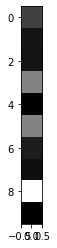

In [9]:
delta = abs(advice.iloc[:,[1]] - real.iloc[:,[1]]) / real.iloc[:,[1]]
delta = delta[:-1]
print('delta')
plt.imshow(delta.values,cmap='gray')

# plot 趨勢圖

In [10]:
def get_actor_action(state,request):
    advice,output,stream,_,_ = agent.get_advice(state,request)
    return advice

In [11]:
def get_real_action(state,request):
    
    #load real data
    state = data['mm_state'].inverse_transform(data['state'])
    action = [data['mm_action'].inverse_transform(i) for i in data['action']]
    output = data['mm_output'].inverse_transform(data['output'])
    stream = data['mm_stream'].inverse_transform(data['stream'])
    
    #calculate distance
    distance_state = ((state - set_state)**2).sum()
    distance_output = (output - set_request)**2
    min_distance_idx =  np.argmin(distance_state + distance_output)
    
    # show result
    real = pd.DataFrame(action[min_distance_idx],columns=data['action_col'])
    real.loc['mean'] = real.mean(axis=0)
    real.loc['max'] = real.max(axis=0)
    real.loc['min'] = real.min(axis=0)
    real = real.iloc[-3:,:].T
    real['chinese'] = real.index.map(tag_dict)
    real = real[advice.columns]
    return real

In [12]:
pred = {}
real = {}
for t in [0,0.25,0.5,0.75]:
    pred[t] = get_actor_action([t,30],8000)
    real[t] = get_real_action([t,30],8000)

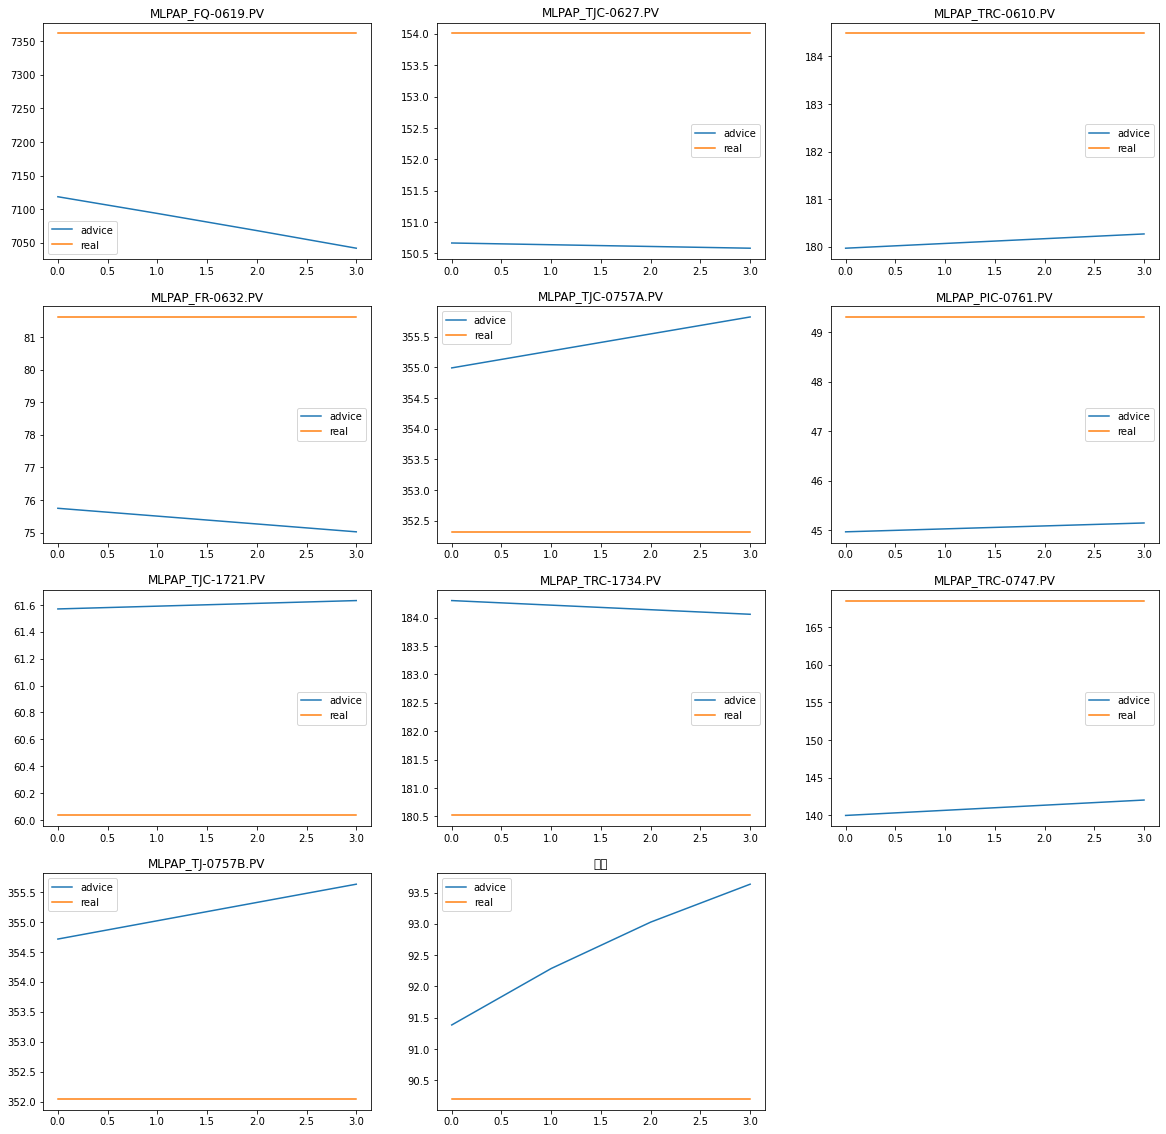

In [13]:
plt.figure(figsize=(20,20))
for idx,y_name in enumerate(data['action_col']):
    plt.subplot(4,3,idx+1)
    plt.plot([v.loc[y_name,'mean'] for k,v in pred.items()],label='advice')
    plt.plot([v.loc[y_name,'mean'] for k,v in real.items()],label='real')
    plt.title(y_name)
    plt.legend()
plt.show()